# Setup

In [167]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Get the Data

## Download the Data

In [168]:
import os
import pandas as pd

def load_gold_data():
    csv = os.path.join("/home/polina/IdeaProjects/Intelligent-Systems/Task5/gold.csv")
    return pd.read_csv(csv)

## Take a Quick Look at the Data Structure

In [169]:
gold = load_gold_data()
gold.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,289.5,289.5,280.0,283.7,21621,USD
1,2000-01-05,283.7,285.0,281.0,282.1,25448,USD
2,2000-01-06,281.6,282.8,280.2,282.4,19055,USD
3,2000-01-07,282.5,284.5,282.0,282.9,11266,USD
4,2000-01-10,282.4,283.9,281.8,282.7,30603,USD


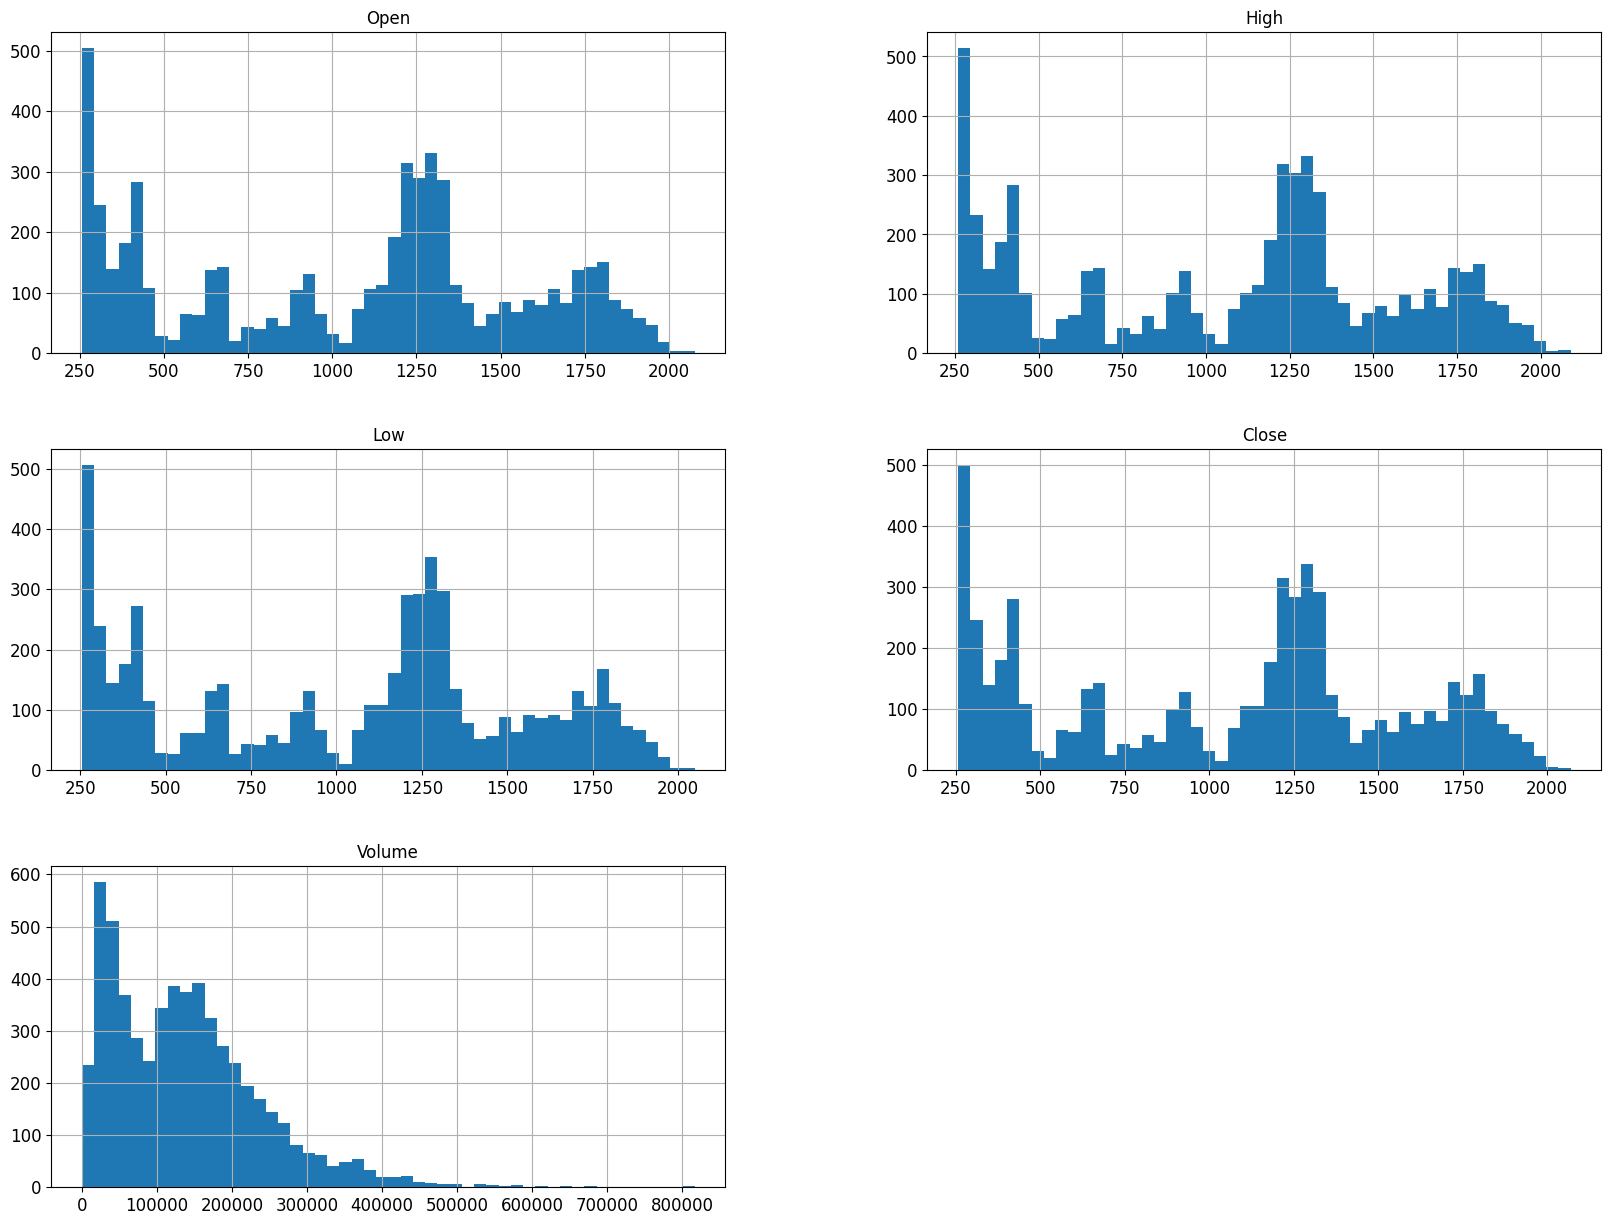

In [170]:
%matplotlib inline
import matplotlib.pyplot as plt
gold.hist(bins=50, figsize=(20,15))
plt.show()

In [171]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5703 entries, 0 to 5702
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5703 non-null   object 
 1   Open      5703 non-null   float64
 2   High      5703 non-null   float64
 3   Low       5703 non-null   float64
 4   Close     5703 non-null   float64
 5   Volume    5703 non-null   int64  
 6   Currency  5703 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 312.0+ KB


In [172]:
gold["Currency"].value_counts()

USD    5703
Name: Currency, dtype: int64

## Create a Test Set

In [173]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [174]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [175]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [176]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [177]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [178]:
gold["Currency"].value_counts()

USD    5703
Name: Currency, dtype: int64

In [179]:
gold = gold.drop("Currency", axis=1)
gold = gold.drop("Date", axis=1)

In [180]:
gold.head()

,Open,High,Low,Close,Volume
0,289.5,289.5,280.0,283.7,21621
1,283.7,285.0,281.0,282.1,25448
2,281.6,282.8,280.2,282.4,19055
3,282.5,284.5,282.0,282.9,11266
4,282.4,283.9,281.8,282.7,30603


In [181]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(gold, test_size=0.2, random_state=42)
test_set.head()

,Open,High,Low,Close,Volume
1436,469.0,472.7,467.4,469.3,43497
748,346.0,353.5,343.6,351.6,37931
3463,1286.4,1294.8,1259.6,1268.2,186264
1448,465.8,467.4,462.0,463.2,59338
4351,1280.0,1280.0,1266.0,1277.5,302842


<AxesSubplot: >

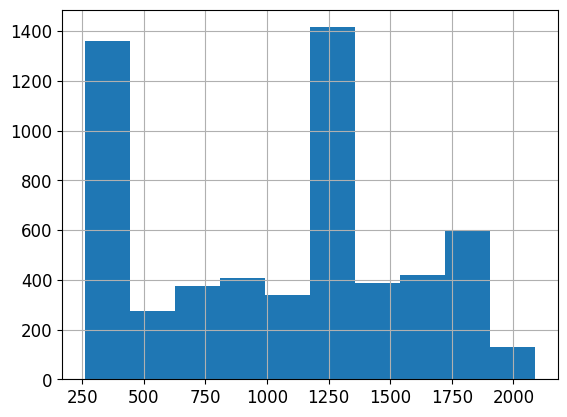

In [182]:
gold["High"].hist()

<AxesSubplot: >

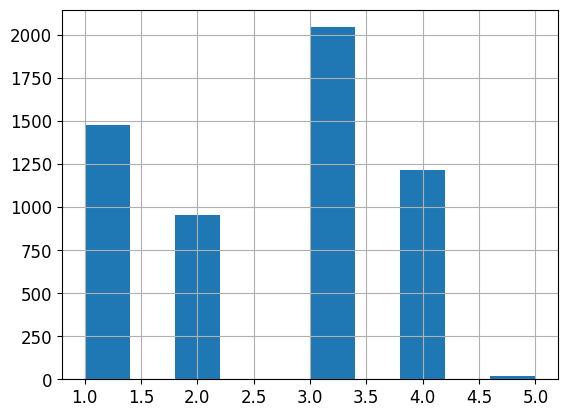

In [183]:
gold["High_cat"] = pd.cut(gold["High"],
                            bins=[0, 500, 1000, 1500, 2000, np.inf],
                            labels=[1, 2, 3, 4, 5])
gold["High_cat"].hist()

In [184]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(gold, gold["High_cat"]):
    strat_train_set = gold.loc[train_index]
    strat_test_set = gold.loc[test_index]

In [185]:
strat_test_set["High_cat"].value_counts() / len(strat_test_set)

3    0.358457
1    0.258545
4    0.212971
2    0.166521
5    0.003506
Name: High_cat, dtype: float64

In [186]:
gold["High_cat"].value_counts() / len(gold)

3    0.358583
1    0.258636
4    0.212695
2    0.166930
5    0.003156
Name: High_cat, dtype: float64

In [187]:
from sklearn.model_selection import train_test_split

def income_cat_proportions(data):
    return data["High_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(gold, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(gold),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [188]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.258636,0.258545,0.276950,7.081092,-0.035057
2,0.166930,0.166521,0.163891,-1.820145,-0.245067
3,0.358583,0.358457,0.349693,-2.479188,-0.035057
4,0.212695,0.212971,0.205960,-3.166687,0.129766
5,0.003156,0.003506,0.003506,11.072159,11.072159


In [189]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("High_cat", axis=1, inplace=True)

In [190]:
gold.head()

,Open,High,Low,Close,Volume,High_cat
0,289.5,289.5,280.0,283.7,21621,1
1,283.7,285.0,281.0,282.1,25448,1
2,281.6,282.8,280.2,282.4,19055,1
3,282.5,284.5,282.0,282.9,11266,1
4,282.4,283.9,281.8,282.7,30603,1


# Discover and Visualize the Data to Gain Insights

In [191]:
gold = strat_train_set.copy()

<AxesSubplot: xlabel='Open', ylabel='Close'>

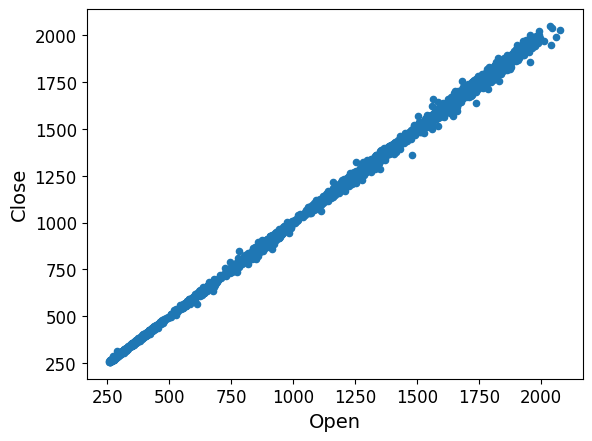

In [192]:
gold.plot(kind="scatter", x="Open", y="Close")

<AxesSubplot: xlabel='Open', ylabel='Close'>

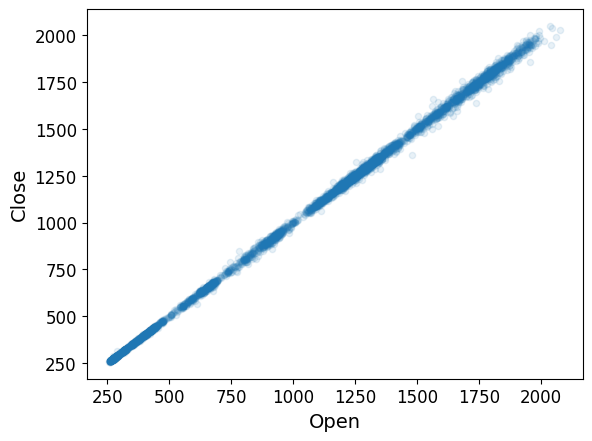

In [193]:
gold.plot(kind="scatter", x="Open", y="Close", alpha = 0.1)


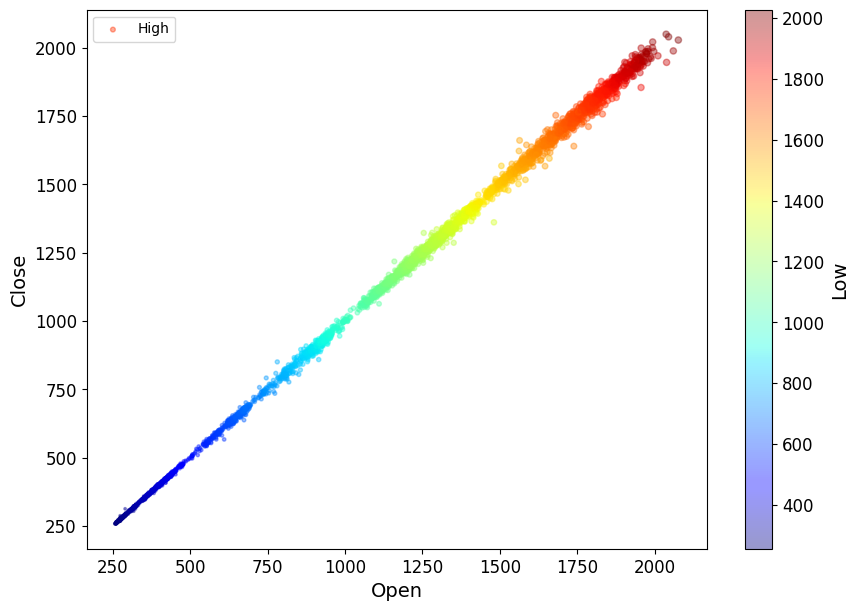

In [194]:
gold.plot(kind="scatter", x="Open", y="Close", alpha=0.4,
             s=gold["High"]/100, label="High", figsize=(10,7),
             c="Low", cmap=plt.get_cmap("jet"), colorbar=True,
             )
plt.legend()

## Looking for Correlations

# Prepare the Data for Machine Learning Algorithms

In [195]:
corr_matrix = gold.corr()
corr_matrix["High"].sort_values(ascending=False)

High      1.000000
Open      0.999875
Close     0.999857
Low       0.999768
Volume    0.693549
Name: High, dtype: float64

array([[<AxesSubplot: xlabel='Open', ylabel='Open'>,
        <AxesSubplot: xlabel='Close', ylabel='Open'>,
        <AxesSubplot: xlabel='High', ylabel='Open'>,
        <AxesSubplot: xlabel='Low', ylabel='Open'>,
        <AxesSubplot: xlabel='Volume', ylabel='Open'>],
       [<AxesSubplot: xlabel='Open', ylabel='Close'>,
        <AxesSubplot: xlabel='Close', ylabel='Close'>,
        <AxesSubplot: xlabel='High', ylabel='Close'>,
        <AxesSubplot: xlabel='Low', ylabel='Close'>,
        <AxesSubplot: xlabel='Volume', ylabel='Close'>],
       [<AxesSubplot: xlabel='Open', ylabel='High'>,
        <AxesSubplot: xlabel='Close', ylabel='High'>,
        <AxesSubplot: xlabel='High', ylabel='High'>,
        <AxesSubplot: xlabel='Low', ylabel='High'>,
        <AxesSubplot: xlabel='Volume', ylabel='High'>],
       [<AxesSubplot: xlabel='Open', ylabel='Low'>,
        <AxesSubplot: xlabel='Close', ylabel='Low'>,
        <AxesSubplot: xlabel='High', ylabel='Low'>,
        <AxesSubplot: xlabel='Low'

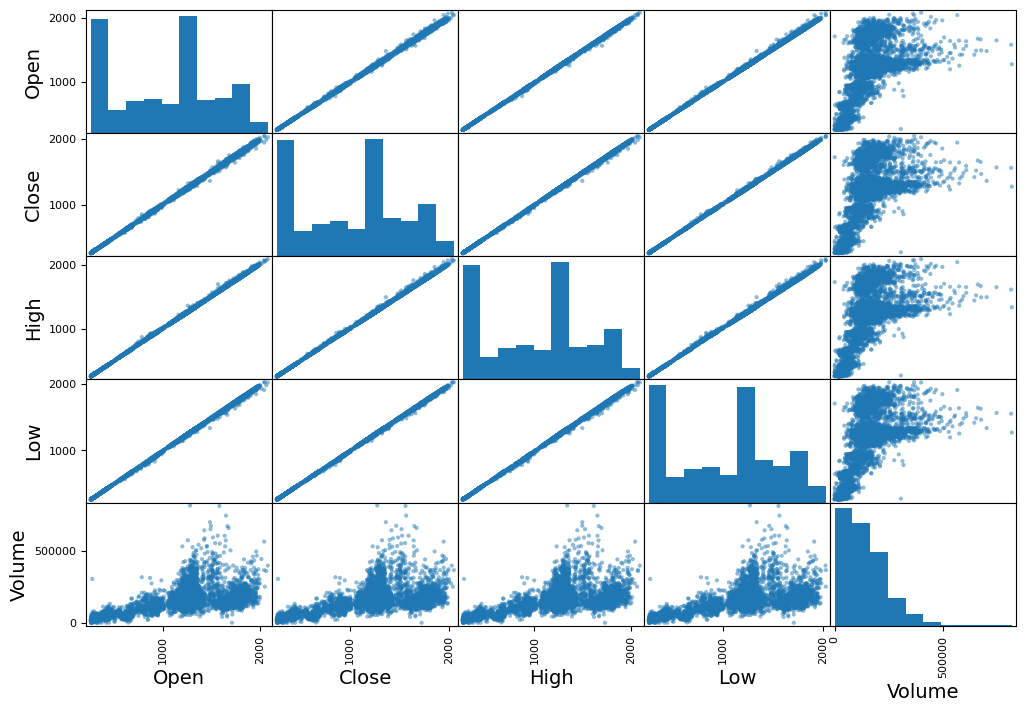

In [196]:
from pandas.plotting import scatter_matrix
attributes = ["Open", "Close", "High","Low", "Volume"]

scatter_matrix(gold[attributes], figsize=(12, 8))

## Transformation Pipelines

In [197]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

full_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

gold_prepared = full_pipeline.fit_transform(gold)

In [198]:
gold_prepared

array([[ 1.44542087,  1.43122073,  1.4414872 ,  1.41939286, -0.01358099],
       [-1.17124136, -1.17704684, -1.17839625, -1.1837384 , -0.51051542],
       [-1.14505741, -1.14779417, -1.14228402, -1.14655907, -0.8616229 ],
       ...,
       [ 0.32605701,  0.32879654,  0.33695801,  0.3383026 ,  0.07125245],
       [ 1.60290963,  1.58799975,  1.58865422,  1.56098255, -0.23276975],
       [ 0.33164035,  0.31636893,  0.31967851,  0.30593925, -0.42089646]])

In [199]:
gold_prepared.shape

(4562, 5)

In [200]:
gold_prepared = full_pipeline.fit_transform(gold)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [201]:
gold_labels = strat_train_set["Volume"].copy()
gold.head()

,Open,High,Low,Close,Volume
5690,1790.8,1796.6,1773.9,1776.7,137832
1301,431.7,432.4,424.5,425.4,86846
1404,445.3,447.7,443.1,444.7,50822
4388,1262.7,1268.5,1252.7,1254.6,255149
1877,656.1,658.7,647.4,650.6,84068


In [202]:
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

kn_classifier = KNeighborsClassifier()
kn_classifier.fit(gold_prepared, gold_labels)

KNeighborsClassifier()

In [203]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(gold_prepared, gold_labels)

LinearRegression()

In [204]:
some_data = gold.iloc[:5]
some_labels = gold_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Labels:", list(some_labels))

Labels: [137832, 86846, 50822, 255149, 84068]


In [205]:
some_data_prepared

array([[ 1.44542087,  1.43122073,  1.4414872 ,  1.41939286, -0.01358099],
       [-1.17124136, -1.17704684, -1.17839625, -1.1837384 , -0.51051542],
       [-1.14505741, -1.14779417, -1.14228402, -1.14655907, -0.8616229 ],
       [ 0.42867499,  0.42152559,  0.42956839,  0.41362447,  1.12984774],
       [-0.73920619, -0.74437498, -0.74563204, -0.7499153 , -0.53759116]])

In [206]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

gold_predictions = lin_reg.predict(gold_prepared)
lin_mse = mean_squared_error(gold_labels, gold_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

4.439431878903612e-11

In [207]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(gold_prepared, gold_labels)

housing_predictions = tree_reg.predict(gold_prepared)
tree_mse = mean_squared_error(gold_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Better Evaluation Using Cross-Validation

In [224]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, gold_prepared, gold_labels,
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([ 587.1696287 ,  700.66883802, 3266.39424705,  657.37083816,
        455.18251352, 2162.13455486, 1220.28697912,  446.5770768 ,
        574.9784359 , 1446.09517852])

In [209]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 579.88999938  683.24624483 3306.7598471  2723.66319133  529.54587256
 3428.34282029 1215.20004039  444.46604818  499.25516232  736.26978572]
Mean: 1414.6639012094822
Standard deviation: 1168.029264188272


In [210]:
kn_scores = cross_val_score(kn_classifier, gold_prepared, gold_labels,
                             scoring="neg_mean_squared_error", cv=2)
kn_rmse_scores = np.sqrt(-kn_scores)
display_scores(kn_rmse_scores)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Scores: [11642.22991801 11234.73286822]
Mean: 11438.481393117288
Standard deviation: 203.74852489376462


In [211]:
lin_scores = cross_val_score(lin_reg, gold_prepared, gold_labels, scoring="neg_mean_squared_error", cv=2)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [7.36693637e-11 5.84614948e-11]
Mean: 6.606542928345766e-11
Standard deviation: 7.603934451112338e-12


In [212]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(gold_prepared, gold_labels)
forest_scores = cross_val_score(lin_reg, gold_prepared, gold_labels,scoring="neg_mean_squared_error", cv=2)
forest_rmse_scores = np.sqrt(-lin_scores)
display_scores(forest_rmse_scores)

Scores: [7.36693637e-11 5.84614948e-11]
Mean: 6.606542928345766e-11
Standard deviation: 7.603934451112338e-12


In [213]:
scores = cross_val_score(kn_classifier, gold_prepared, gold_labels, scoring="neg_mean_squared_error", cv=2)
pd.Series(np.sqrt(-scores)).describe()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


count        2.000000
mean     11438.481393
std        288.143927
min      11234.732868
25%      11336.607131
50%      11438.481393
75%      11540.355656
max      11642.229918
dtype: float64

# Fine-Tune Your Model

## Grid Search

In [214]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(gold_prepared, gold_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [215]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 10}

In [216]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=10)

In [217]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.052866,0.008996,0.004386,0.001121,False,2,3,"{'bootstrap': False, 'max_features': 2, 'n_est...",-1.015967e+08,-7.353093e+07,...,-1.575614e+08,1.283339e+08,6,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
1,0.139151,0.008163,0.008407,0.002549,False,2,10,"{'bootstrap': False, 'max_features': 2, 'n_est...",-4.182389e+07,-9.003729e+07,...,-6.231784e+07,3.489991e+07,5,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2,0.054229,0.003940,0.003874,0.000598,False,3,3,"{'bootstrap': False, 'max_features': 3, 'n_est...",-2.942877e+07,-3.809780e+07,...,-4.649145e+07,4.431122e+07,4,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
3,0.169803,0.008796,0.007575,0.001801,False,3,10,"{'bootstrap': False, 'max_features': 3, 'n_est...",-5.099688e+06,-2.611033e+07,...,-2.476442e+07,2.059518e+07,3,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
4,0.063212,0.003905,0.003689,0.001019,False,4,3,"{'bootstrap': False, 'max_features': 4, 'n_est...",-3.565606e+06,-1.303412e+07,...,-1.941073e+07,2.529120e+07,2,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
5,0.198434,0.010446,0.008581,0.001288,False,4,10,"{'bootstrap': False, 'max_features': 4, 'n_est...",-9.143099e+06,-1.137382e+07,...,-1.295653e+07,1.286942e+07,1,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0


## Analyze the Best Models and Their Errors

In [218]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.00104223, 0.15007695, 0.00177877, 0.00137716, 0.84572488])

In [219]:
attributes = list(gold)
sorted(zip(feature_importances, attributes), reverse=True)

[(0.8457248849385195, 'Volume'),
 (0.15007694856231085, 'High'),
 (0.0017787695086325217, 'Low'),
 (0.0013771647535133875, 'Close'),
 (0.0010422322370237963, 'Open')]

## Evaluate Your System on the Test Set

In [220]:
final_model = grid_search.best_estimator_
X_test = strat_test_set
y_test = strat_test_set["High"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

171229.61013302318

In [221]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([163799.69453197, 178350.27009749])

In [222]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(163799.6945319738, 178350.27009748624)

In [223]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(163807.76161165276, 178342.86082822087)